# Objective

Illustrate a series of post-deployment checks to monitor model performance

In [1]:
import requests
import random
import session_info

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('talk')
session_info.show()

**Notice that there is no `sklearn` import.**

# Introduction

The deployment phase begins when we hit `joblib.dump()` on our final model 😀. 

In this phase, there are several other moving parts get added to the mix increasing the 'technical debt' of a performant prediction system.

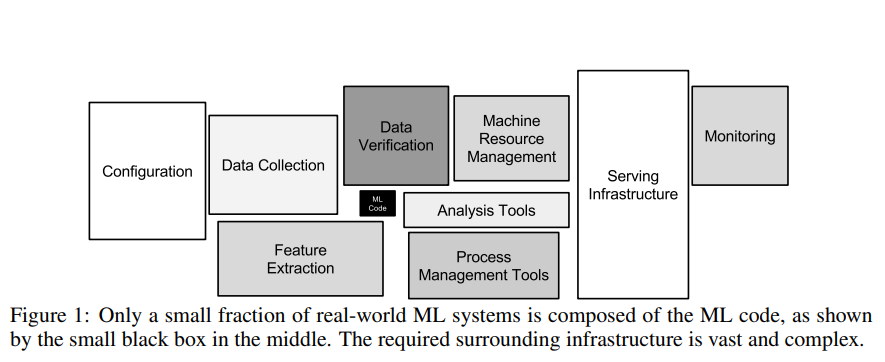

During deployment, the prime focus is in ensuring that there are minimal prediction errors (i.e., minimal system failures) on live data and that the system is maintainable.

In this notebook, we look at how models can be deployed as a web service (see: `app.py`) and how a series of post-deployment checks should be conducted.


# REST APIs

An important mechanism through which customers access models is by sending a HTTP request. 

An HTTP request is a formal, standardized mechanism of asking a web service (hosted on a *server*) for a response. In this process, we say that the web service exposes an *endpoint* to the consumer of the response (referred to as a *client*). When the request and response follow a set of rules (refer attached slides), the service is said to follow the REST protocol.

**Example 1: A `GET` request to a news website**

`GET` requests allow us to *read* information hosted on a server.

In [3]:
url = 'https://theprint.in'

In [4]:
response = requests.get(url)

In [5]:
response.status_code

200

There are several [HTTP response codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes). Of particular relevance to us are:
- `200` indicates that the request was sucessfully executed and a response was received
- `403` indicates an unauthorized request
- `404` indicates that the resource was not found
- `500` indicates a server error

In sum, `40X` series of response codes indicate a problem on the client side, while a `50X` series of response codes indicate a problem on the server side.

In [6]:
type(response.text)

str

<div class="alert alert-block alert-success">

<b>Task 1 (3 minutes)</b> 

Pick a website that you visit often. Send a `get` request to the website and inspect the status code of the response.
    
</div>

Add code cells below as required.

<div class="alert alert-block alert-success">

<b>Task 2 (3 minutes)</b> 

Send a `get` request to the url: https://github.com/pgurazada/talks/1. 

What is the status code? What does it indicate?
    
</div>

In [7]:
url = 'https://github.com/pgurazada/talks/1'

**Example 2: A `POST` request**

A `POST` request allows us to send information to a server. Common applications include filling in form data (e.g., name, email address). In our context, we design endpoints to allow customers to send us input features for a model to return a prediction.

In [8]:
url = "https://httpbin.org/post"

In [9]:
payload = {'name': 'dsba', 'email': 'dsba@greatlearning.in'}

In [10]:
response = requests.post(url, data=payload)

In [11]:
response.status_code

200

In [12]:
print(response.text)

{
  "args": {}, 
  "data": "", 
  "files": {}, 
  "form": {
    "email": "dsba@greatlearning.in", 
    "name": "dsba"
  }, 
  "headers": {
    "Accept": "*/*", 
    "Accept-Encoding": "gzip, deflate, br", 
    "Content-Length": "39", 
    "Content-Type": "application/x-www-form-urlencoded", 
    "Host": "httpbin.org", 
    "User-Agent": "python-requests/2.28.1", 
    "X-Amzn-Trace-Id": "Root=1-63b79292-454022db4b9623ee49d94025"
  }, 
  "json": null, 
  "origin": "124.123.106.38", 
  "url": "https://httpbin.org/post"
}



# Developing a web service

Let us discuss how `app.py` works. There are three components of `Flask` that allow us to serve REST-ful responses. Incoming `JSON` requests are handled as a `Flask` `request` while the model outputs are converted to `JSON` by the `jsonify` function. 

The flask `app` allows us to encode specific triggers based on end point using decorators.

<div class="alert alert-block alert-success">

<b>Task 3 (5 minutes)</b> 

Run the following steps in a new Anaconda terminal:

`conda activate testenv`

`python app.py`
    
</div>

# Monitoring

The process of monitoring real-world deployments is usually divided into two parts - pre-rollout monitoring and post-rollout monitoring.

Before a model is completely rolled out, it is common practise to gradually ramp up by checking for performance degradations using A/B tests. A *rollback plan* is put in place in case the A/B tests report degradation. The degradation measures here is the performance of the overall system (e.g., latency) and not model accuracy.

## Pre-rollout Checks

Before final rollout, a series of checks are usually conducted in either:

(a) a *staging* environment, that is, exact replica of development environment where historical data is tested on the current model and the proposed upgrade

(b) a *canary* evnironment, that is, a live environment where 1% - 5% of the users are exposed to the proposed upgrade

**Before running the code cells in the rest of the notebook ensure that you have finished Task 3 above.**

In [13]:
url = 'http://localhost:8000/v3/diamond'

### Check 1: Prediction flow

In this check, we ascertain that the model is serving predictions without error in a synchronous or asynchronous mode. The idea here is to confirm that model works within the confines of the existing system architecture (see figure below). There is usually a API gateway or an event broker that handles the flow of requests coming in and directs them to the appropriate end-point. The closer our staging environment is to the final system configuration the more robust this check is.

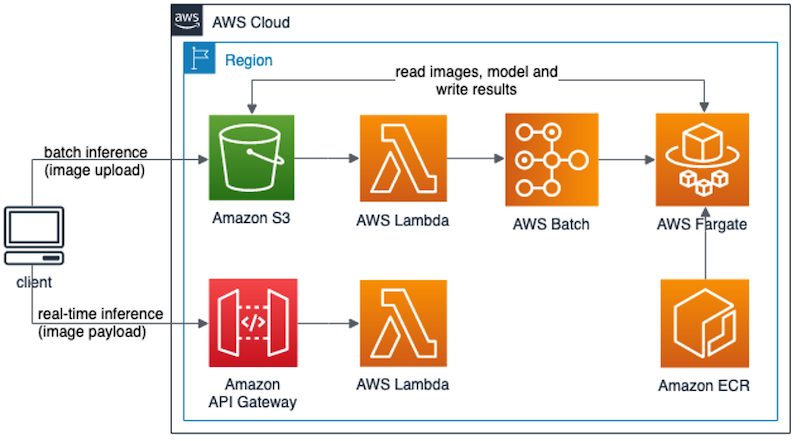

[Source](https://aws.amazon.com/blogs/machine-learning/machine-learning-inference-at-scale-using-aws-serverless/)

#### Streaming/Synchronous/Real-time Inference

In [14]:
stream_payload = {
    "shape": "Round",
    "carat": 0.88,
    "cut": "Very Good",
    "color": "J",
    "clarity": "SI2",
    "type": "natural",
    "report": "GIA"
}

In [15]:
response = requests.post(url, json=stream_payload)

<div class="alert alert-block alert-success">

<b>Task 4 (2 minutes)</b> 

What is the status code of the response? Did the endpoint pass the streaming check?    
</div>

Write your code below.

#### Batch/Asynchronous Inference

In [16]:
batch_payload = [
    {
        "shape": "Round",
        "carat": 0.88,
        "cut": "Very Good",
        "color": "J",
        "clarity": "SI2",
        "type": "natural",
        "report": "GIA"
    }, 
    {
        "shape": "Round",
        "carat": 1.5,
        "cut": "Very Good",
        "color": "J",
        "clarity": "SI2",
        "type": "natural",
        "report": "GIA"
    },
     {
        "shape": "Round",
        "carat": 5,
        "cut": "Very Good",
        "color": "J",
        "clarity": "SI2",
        "type": "natural",
        "report": "GIA"
    },
     {
        "shape": "Round",
        "carat": 10,
        "cut": "Very Good",
        "color": "J",
        "clarity": "SI2",
        "type": "natural",
        "report": "GIA"
    }
]

In [17]:
for payload in batch_payload:
    response = requests.post(url, json=payload)
    print(response.json())

{'expected price': 2260.0}
{'expected price': 6770.0}
{'expected price': 54120.0}
{'expected price': 241870.0}


### Check 2: Directional expectation

In a directional expectation check, we ascertain that known business rules are validated by the response from the model server. We formulate these business rules as test payloads to the endpoint and observe if the business rules are validated by the response.

<div class="alert alert-block alert-success">

<b>Task 5 (5 minutes)</b> 

Write a test to implement your understanding of the business rule - if we increase the carat, do you expect the price increase or decrease?

To accomplish this task, you will need to change the baseline payload below, send a request to the server and see if the response makes business sense.

Does the deployed model pass the directional expectation check?

</div>

Add more code cells as required.

In [18]:
baseline_payload = {
    "shape": "Round",
    "carat": 0.88,
    "cut": "Very Good",
    "color": "J",
    "clarity": "SI2",
    "type": "natural",
    "report": "GIA"
}

In [19]:
test_payload = {

    # your code here
}

### Check 3: Perturbation

The idea here is that by changing the input values by a small amount, we should not observe dramatic changes in the predictions. The magnitude of a "small perturbation" is defined using the business context.

<div class="alert alert-block alert-success">

<b>Task 6 (3 minutes)</b> 

Perturb the carat value of the base payload below and confirm if the deployed model passes the perturbation check.

</div>

Add more code cells as required.

In [20]:
baseline_payload = {
    "shape": "Round",
    "carat": 1,
    "cut": "Very Good",
    "color": "J",
    "clarity": "SI2",
    "type": "natural",
    "report": "GIA"
}

In [21]:
test_payload = {

    # your code here
}

### Check 4: Critical subgroups

Check the veracity of predictions on a subgroup of data that is critical to your business. You should have a strong business context around the accuracy of predictions on this subgroup that should be used to whet the accuracy of predictions. Often this critical subgroup is referred to as the 'golden set' on which the model cannot be making incorrect predictions. 

<div class="alert alert-block alert-success">

<b>Task 7 (3 minutes)</b> 

From prior history, it is known that a diamond of the following configuration has fetched a price of around USD 100,000:

- "shape": "Round"
- "carat": 10 - 12
- "cut": "Very Good"
- "color": "J"
- "clarity": "SI2"
- "type": "natural"
- "report": "GIA"

This configuration forms about 30% of sales and is a critical component of your product portfolio. 

Write two test cases to confirm if the model is making resonable predictions for this critical subgroup.

</div>

In [22]:
test_payload1 = {

    # your code here
}

In [23]:
test_payload2 = {

    # your code here
}

### Check 5: Target distribution

This is a check to account for drift in the contours of data when the training was executed and when the model is facing live data. Alerts should be set up when the live feature distribution moves away from the training data distribution (more on this in post-rollout monitoring).

A more critical alert is when the target distribution from the model is deviant from the current baseline (i.e., the version currently in production). Remember that the target predictions are the closest to the customer and hence target distribution deviations are a more serious concern. This check is usually conducted within a *canary* environment with close monitoring of the predictions.

#### Target distribution

We will use test features as a proxy for streaming data and test targets as a proxy for the predictions from the current baseline. 

In [24]:
test_features = pd.read_csv('../01_train/data/20230104_test_features.csv')

In [25]:
test_target = pd.read_csv('../01_train/data/20230104_test_target.csv')

Let us consider a sample batch of 100 predictions and compare these with the distribution observed on the test data. By tagging and versioning the training data along with the model, we can track the data used to train a specific model.

In [26]:
BATCH_SIZE = 100

In [27]:
batch_payload = []

for i in random.choices(test_features.index, k=BATCH_SIZE):
    sample = test_features.iloc[i].to_dict()
    batch_payload.append(sample)

In [28]:
predictions = []

for payload in batch_payload:
    response = requests.post(url, json=payload)
    predictions.append(response.json()['expected price'])

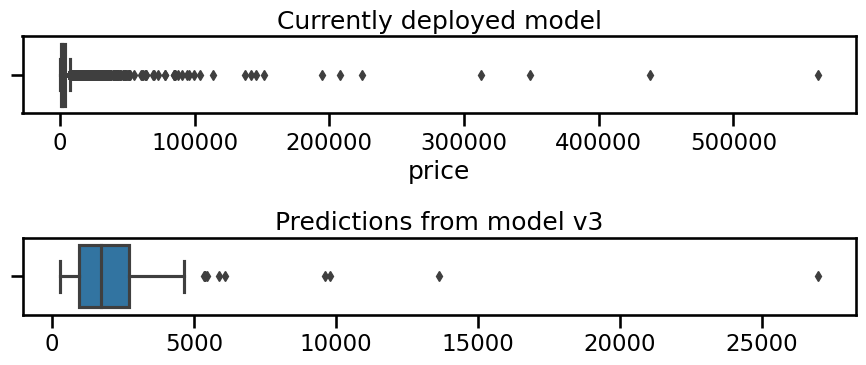

In [29]:
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='price', data=test_target)
plt.title("Currently deployed model")
plt.subplot(212)
sns.boxplot(x=predictions)
plt.title("Predictions from model v3")
plt.tight_layout()

<div class="alert alert-block alert-success">

<b>Task 8</b> 
    
Think of a statistical method to verify that the predictions from model v3 is not any different in distribution from the currently deployed model.

</div>

## Post-rollout Checks

After a full roll-out, models should be monitored for two aspects - **data drift** and **concept drift**.

*Data drift* is best understood as a change in the underlying distribution of the features over time. For example, if the age of our target customers changes over time and this variable is a key predictor, model performance will degrade over time. 


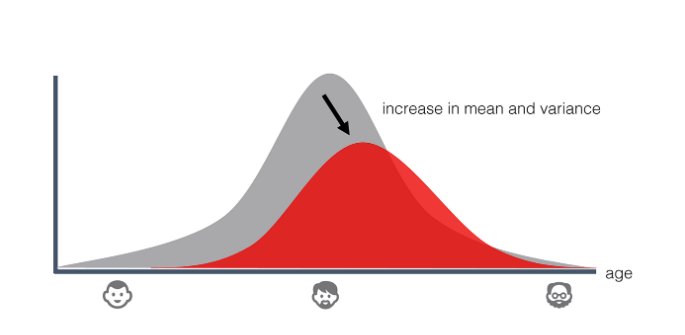



[Source](https://towardsdatascience.com/machine-learning-in-production-why-you-should-care-about-data-and-concept-drift-d96d0bc907fb)

*Concept Drift* is best understood as the breakdown of the learned relationship between the inputs and outputs. Concept drift is hard to pinpoint since the change in performance could be subtle; however, dramatic concept drifts are rare but easy to spot.

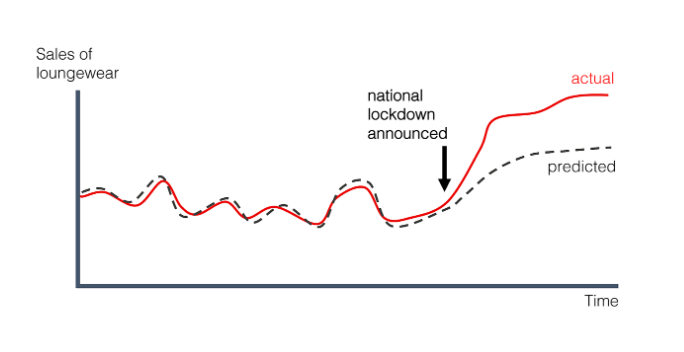

[Source](https://towardsdatascience.com/machine-learning-in-production-why-you-should-care-about-data-and-concept-drift-d96d0bc907fb)

When drift goes beyond reasonable bounds, it is time to retrain.